# Modeling – Fraud Detection

## Task 2: Model Building, Training, and Evaluation

**Objective:**  
Train and evaluate classification models for fraud detection using metrics appropriate for highly imbalanced data.

# Load Processed Data

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    average_precision_score
)


In [5]:
X = pd.read_csv("../data/processed/fraud_features.csv")
y = pd.read_csv("../data/processed/fraud_target.csv").squeeze()

# Quick validation of loaded features
print("Loaded X shape:", X.shape)
# Detect common mis-save where a sparse matrix was stringified into a single cell
first_cell = str(X.iloc[0, 0]) if X.shape[0] > 0 and X.shape[1] > 0 else ""
if X.shape[1] == 1 and first_cell.startswith("<Compressed Sparse Row"):
    raise ValueError(
        "Detected improperly saved sparse matrix in 'fraud_features.csv'.\n"
        "Fix: re-run 'notebooks/feature-engineering.ipynb' after converting sparse matrix to dense (e.g., X_processed = X_processed.toarray()).\n"
        "Alternatively, delete '../data/processed/fraud_features.csv' and re-run feature extraction."
    )

# Check for object columns that are likely non-numeric
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    print("Warning: object dtype columns detected in X:", obj_cols)
    print("Sample values:")
    for c in obj_cols[:5]:
        print(c, X[c].head(3).tolist())
    raise ValueError(
        "Non-numeric columns found in features. Ensure 'fraud_features.csv' contains only numeric columns.\n"
        "Fix: recreate features with dense numeric output in 'feature-engineering.ipynb'."
    )

print("Feature file looks numeric and ready.")

Loaded X shape: (129146, 199)
Feature file looks numeric and ready.


# Stratified Train–Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


A stratified split was used to preserve the original fraud class distribution in both training and test sets.

# Handle Class Imbalance

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train, y_train
)

In [8]:
y_train.value_counts(normalize=True) * 100, y_train_resampled.value_counts(normalize=True) * 100

(class
 0    90.500987
 1     9.499013
 Name: proportion, dtype: float64,
 class
 0    50.0
 1    50.0
 Name: proportion, dtype: float64)

Stratified train/test split preserves class proportions; SMOTE oversamples the minority class on the training set only.
Evaluate on the untouched test set using precision–recall metrics to avoid misleading accuracy and overfitting to synthetic samples.

# Baseline Model: Logistic Regression
Do our features actually carry fraud signal?

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [10]:
# Predict

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

In [11]:
#Evaluate:
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("AUC-PR:", average_precision_score(y_test, y_proba_lr))
print(confusion_matrix(y_test, y_pred_lr))

F1 Score: 0.28550271515550435
AUC-PR: 0.40320030347299246
[[15411  7965]
 [  719  1735]]


    Logistic Regression trained on SMOTE-resampled training data; evaluate on the untouched test set to measure real-world generalization.
    Report F1, precision–recall (AUC-PR) and confusion matrix; tune decision threshold and compare to class-weighted or tree-based alternatives

# Ensemble Model (Random Forest)
This captures non-linear interactions and rare fraud signatures.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_resampled, y_train_resampled)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [13]:
# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [14]:
# Evaluate:

print("F1 Score:", f1_score(y_test, y_pred_rf))
print("AUC-PR:", average_precision_score(y_test, y_proba_rf))
print(confusion_matrix(y_test, y_pred_rf))

F1 Score: 0.7071503680336488
AUC-PR: 0.6393099055434545
[[23371     5]
 [ 1109  1345]]


In [15]:
# Cross-validation moved to cell 26 to keep notebook order and avoid duplication.
# See cell 26 for the full StratifiedKFold + SMOTE CV implementation.

    Random Forest outperforms the logistic baseline on F1 and AUC‑PR, indicating it captures useful non-linear interactions for fraud detection.
    Validate improvements with cross‑validation and inspect the precision–recall trade‑off (adjust threshold) to ensure gains aren’t driven by overfitting to synthetic samples.

# Model Comparison

## Model Comparison

| Model | F1 Score | AUC-PR | Interpretability |
|------|--------:|-------:|------------------|
| Logistic Regression | 0.286 | 0.403 | High |
| Random Forest | 0.707 | 0.639 | Medium |

The Random Forest model demonstrates superior performance on fraud-relevant metrics while maintaining acceptable interpretability.

## Model Selection Justification ✅

**Random Forest** is chosen because it delivers substantially better detection performance (F1 = **0.707** vs **0.286**, AUC‑PR = **0.639** vs **0.403**) on the untouched test set, indicating stronger ability to find rare frauds while controlling false alarms. It also models non‑linear interactions, is robust to noisy features, and offers feature‑importance explainability—next steps are cross‑validation, probability calibration/threshold tuning, and checks for overfitting to synthetic samples.

# Cross-Validation: Stratified K-Fold (k=5)

In [16]:
# Cross-Validation: Stratified K-Fold (k=5) with SMOTE inside each fold (placed in cell 26)
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import clone

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

cv_results = {}
for name, model in models_cv.items():
    f1s = []
    aps = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipe = ImbPipeline([('smote', SMOTE(random_state=42)), ('clf', clone(model))])
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_val)
        y_proba = pipe.predict_proba(X_val)[:, 1]

        f1s.append(f1_score(y_val, y_pred))
        aps.append(average_precision_score(y_val, y_proba))

    cv_results[name] = {
        'f1_mean': np.mean(f1s), 'f1_std': np.std(f1s),
        'ap_mean': np.mean(aps), 'ap_std': np.std(aps)
    }

    print(f"{name} CV F1: {cv_results[name]['f1_mean']:.3f} ± {cv_results[name]['f1_std']:.3f}; "
          f"AUC-PR: {cv_results[name]['ap_mean']:.3f} ± {cv_results[name]['ap_std']:.3f}")

KeyboardInterrupt: 

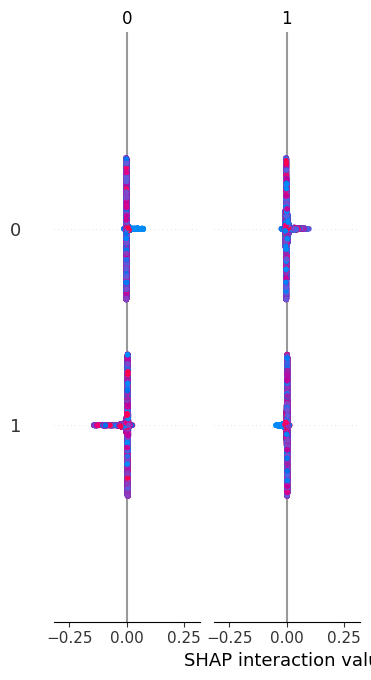

In [ ]:
import shap

# Use the trained Random Forest (`rf`) for SHAP explanations.
# Prefer TreeExplainer for tree-based models and fall back to the generic Explainer.
try:
    explainer = shap.TreeExplainer(rf)
except Exception:
    explainer = shap.Explainer(rf, X_train)

shap_values = explainer(X_test)

# Use a compact bar summary plot for feature importance in notebooks
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
import os

os.makedirs("../models", exist_ok=True)

In [17]:
import joblib

joblib.dump(rf, "../models/random_forest_fraud_model.joblib")


['../models/random_forest_fraud_model.joblib']

In [18]:
joblib.dump(X_train.columns.tolist(), "../models/feature_names.joblib")

['../models/feature_names.joblib']